In [1]:
import pandas as pd
import numpy as np
import gc#垃圾回收机制
import time
import pickle#数据保存为一个pkl格式
import seaborn as sns
from tqdm import tqdm
from itertools import product
import matplotlib.pyplot as plt
from xgboost import XGBRegressor#特征非常少数据多的时候
from sklearn import preprocessing 
from xgboost import plot_importance
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [2]:
def plot_features(booster, figsize):    ##绘图函数
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

In [3]:
def downcast_dtypes(df):#数据类型转换函数
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float16)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

## 数据的读入

In [4]:
train = pd.read_csv("DATA/sales_train_v2.csv")
test = pd.read_csv("DATA/test.csv").set_index("ID")
shops = pd.read_csv("DATA/shops.csv")
cats = pd.read_csv("DATA/item_categories.csv")
items = pd.read_csv("DATA/items.csv")

##    <font color =red >针对于train数据</font>


##  数据可视化

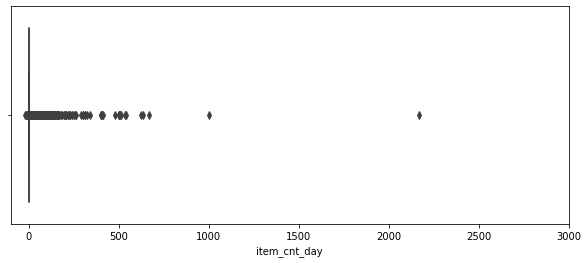

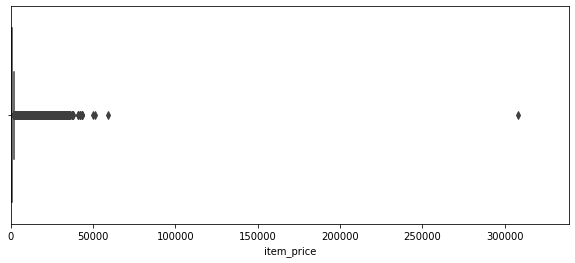

In [5]:
plt.figure(figsize=(10,4))#图的大小
plt.xlim(-100, 3000)#范围
sns.boxplot(x=train.item_cnt_day)#自变量
# plt.show()
plt.figure(figsize=(10,4))#图的大小
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)#最大值乘以1.1
sns.boxplot(x=train.item_price)#自变量
plt.show()

## 数据可视化探索后进行数据的异常值删除

In [6]:
#删除特异值
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1000]

In [7]:
train["item_price"].median()##中值

399.0

In [8]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


## 数据的填充--因为价格是没有负的

In [9]:
median = train[(train.item_price>0)].item_price.median()

In [10]:
train.loc[train.item_price<0, 'item_price'] = median#loc 查找该列小于0的数据填充成中值

In [11]:
#清除重复行--删掉没必要的减少计算量
train.drop_duplicates(subset=["date","date_block_num","shop_id","item_id","item_price","item_cnt_day"],keep='first',inplace=True)

In [12]:
test["shop_id"].unique()

array([ 5,  4,  6,  3,  2,  7, 10, 12, 28, 31, 26, 25, 22, 24, 21, 15, 16,
       18, 14, 19, 42, 50, 49, 53, 52, 47, 48, 57, 58, 59, 55, 56, 36, 37,
       35, 38, 34, 46, 41, 44, 39, 45], dtype=int64)

## 数据集中的train和test数据集保持一致性

In [13]:
##有几家商店是彼此的复制品,改变训练集和测试集将其更改为同一商店编号
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

#清除训练集中在测试集中不存在的商店并且将数据集重做
train = train.merge(test[['shop_id']].drop_duplicates(), how = 'inner')

## <font color=red>针对于shops数据</font>

In [14]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [15]:
#分解出商店所在城市
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])#分开
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['shop_city'] = LabelEncoder().fit_transform(shops['city'])#直接将其标签编码
#分解出商店名称
shops['name1'] = shops['shop_name'].apply(lambda x: x.lower()).str.replace('[^\w\s]', '').str.replace('\d+','').str.strip()
shops['shop_name1'] = LabelEncoder().fit_transform(shops['name1'])
#分解出商店经营类型
shops['type'] = shops['name1'].apply(lambda x: 'мтрц' if 'мтрц' in x else 'трц' if 'трц' in x else 'трк' 
                                               if 'трк' in x else 'тц' if 'тц' in x else 'тк' if 'тк' in x else 'NO_DATA')
shops["shop_type"] = shops["type"].map({'NO_DATA': 0 ,'мтрц': 1 ,'тк': 2 ,'трк': 3 ,'трц': 4 ,'тц': 5 })

#更新数据shop数据
shops = shops[['shop_id','shop_city','shop_name1','shop_type']]

In [16]:
shops.head()

,shop_id,shop_city,shop_name1,shop_type
0,0,29,56,0
1,1,29,58,5
2,2,0,0,5
3,3,1,1,3
4,4,2,2,5


## <font color=red>针对于item_category_id数据</font>

In [17]:
cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [18]:
#分解出商品名
cats['split'] = cats['item_category_name'].str.split('-')
#分解出商品所在类型
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['item_type'] = LabelEncoder().fit_transform(cats['type'])
# # 去空格
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['item_subtype'] = LabelEncoder().fit_transform(cats['subtype'])
#更新数据
cats = cats[['item_category_id','item_type','item_subtype']]

In [19]:
cats.head()

,item_category_id,item_type,item_subtype
0,0,0,29
1,1,1,9
2,2,1,10
3,3,1,11
4,4,1,13


## <font color=red>针对于item数据</font>

In [21]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [22]:
items["item_name"].unique()

array(['! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D',
       '!ABBYY FineReader 12 Professional Edition Full [PC, Цифровая версия]',
       '***В ЛУЧАХ СЛАВЫ   (UNV)                    D', ...,
       'Язык запросов 1С:Предприятия 8 (+CD). Хрусталева Е.Ю.',
       'Яйцо для Little Inu', 'Яйцо дракона (Игра престолов)'],
      dtype=object)

In [23]:
#分解
items['name_s1'], items['name_s2'] = items['item_name'].str.split('[', 1).str##分割成两个
items['name_s1'], items['name_s3'] = items['item_name'].str.split('(', 1).str##
items['name_s2'] = items['name_s2'].str.replace('[^A-Za-z0-9А-Яа-я]+', ' ').str.lower()#所有大写的均变成小写
items['name_s3'] = items['name_s3'].str.replace('[^A-Za-z0-9А-Яа-я]+', ' ').str.lower()
items = items.fillna('0')#空值用“0”来填充
items['name_1'] = LabelEncoder().fit_transform(items['name_s1'])
items['name_2'] = LabelEncoder().fit_transform(items['name_s2'])
items['name_3'] = LabelEncoder().fit_transform(items['name_s3'])
#更新数据items
items = items[['item_id','item_category_id','name_1','name_2','name_3']]

In [24]:
items.head()

,item_id,item_category_id,name_1,name_2,name_3
0,0,40,0,4,1331
1,1,76,1,64,42
2,2,40,2,4,1011
3,3,40,3,4,1010
4,4,40,4,4,1572


## <font color=red >特征重做--特征添加</font>--目的就是做出item_cnt_month

In [26]:
test.head()

,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


In [27]:
#对于每个月，我们从该月的所有商店/产品的而唯一标识符组合创建一个网格
matrix = []#空列表
cols = ['date_block_num','shop_id','item_id']#训练集里面的特征
for i in train['date_block_num'].unique():#找出每一个,只相当于对每一个进行后续操作,减少运算的意思
    sales = train[train.date_block_num==i]#取出来相当于前提条件
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))#进行添加到列表里面
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)#做成df的格式
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)#转换数据类型
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)#进行排序

In [28]:
matrix.head()

,date_block_num,shop_id,item_id
85820,0,2,19
88148,0,2,27
90860,0,2,28
89310,0,2,29
85240,0,2,32


In [29]:
#求每月该商品的售出量:item_cnt_month
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})##groupby的作用，相当于一个月卖出的东西
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)#重置索引

matrix = pd.merge(matrix, group, on=cols, how='left')#进行组合
##指定这一列的值#做好了标签列
matrix['item_cnt_month'] = (matrix['item_cnt_month'].fillna(0).clip(0,20).astype(np.float16))#把这一列空值进行填充和进行范围限制

In [31]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,19,0.0
1,0,2,27,1.0
2,0,2,28,0.0
3,0,2,29,0.0
4,0,2,32,0.0


In [32]:
test.head()

,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


In [33]:
#要使用时间技巧，将测试集和matrix进行组合
test['date_block_num'] = 34

In [34]:
test.head()

,shop_id,item_id,date_block_num
ID,,,
0,5,5037,34
1,5,5320,34
2,5,5233,34
3,5,5232,34
4,5,5268,34


In [35]:
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)##数据进行组合

In [36]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,19,0.0
1,0,2,27,1.0
2,0,2,28,0.0
3,0,2,29,0.0
4,0,2,32,0.0


In [37]:
matrix.fillna(0, inplace=True) # 34 month

In [38]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,19,0.0
1,0,2,27,1.0
2,0,2,28,0.0
3,0,2,29,0.0
4,0,2,32,0.0


In [39]:
# del test##删除test
gc.collect()#垃圾回收机制

100

## <font color=red >数据组合</font>

In [40]:
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')#数据的组合
matrix = pd.merge(matrix, items, on=['item_id'], how='left')#数据的组合
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
del shops,items,cats
gc.collect()

83

In [41]:
matrix.head().shape##做好的一个数据

(5, 13)

## 把所有的分散的数据做成一个文件，那么这里也提供一个思路是否数据预处理可以结束？直接进行模型的训练和预测？

In [42]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'shop_city',
       'shop_name1', 'shop_type', 'item_category_id', 'name_1', 'name_2',
       'name_3', 'item_type', 'item_subtype'],
      dtype='object')

In [47]:
![image.png](attachment:image.png)

'[image.png]' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


## 真正特征工程

In [43]:
##定义滞后特征函数相当于将df里的滞后
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i##一个一个来
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')#组合
    return df
##定义添加的特征
def tianjia1(list_names,list_num):
    global matrix#全局化
    str1 = list_names[0]
    for i in range(1,len(list_names)):
        str1 = str1+'_and_'+list_names[i]
    str1 = str1+'_avg_item_cnt'##连接符
    
    group = matrix.groupby(list_names).agg({'item_cnt_month': ['mean']})#相当于重做特征变成均值
    group.columns = [str1]
    group.reset_index(inplace=True)#重置索引
##每新增特征之后就要和原来的进行合并
    matrix = pd.merge(matrix, group, on=list_names, how='left')
    matrix[str1] = matrix[str1].astype(np.float16)##转换数据类类型
    matrix = lag_feature(matrix, list_num, str1)
    matrix.drop([str1], axis=1, inplace=True)##和并之后删除

In [44]:
matrix = lag_feature(matrix, [1,2,3], 'item_cnt_month')#将月销售量分别滞后1，2，3个月
tianjia1(['date_block_num'],[1])#将每个月的销售量滞后1个月
tianjia1(['date_block_num', 'item_id'],[1,2,3])#将每个月的每个商品的平均销售量分别滞后1，2，3个月
tianjia1(['date_block_num', 'shop_id'],[1,2,3])#将每个月的每个商店的平均销售量分别滞后1，2，3个月
tianjia1(['date_block_num', 'shop_city'],[1])
tianjia1(['date_block_num', 'shop_name1'],[1])
tianjia1(['date_block_num', 'shop_type'],[1])
tianjia1(['date_block_num', 'item_category_id'],[1])
tianjia1(['date_block_num', 'item_type'],[1])
tianjia1(['date_block_num', 'item_subtype'],[1])
tianjia1(['date_block_num', 'shop_id', 'item_id'],[1])
tianjia1(['date_block_num', 'shop_id', 'name_1'],[1])
tianjia1(['date_block_num', 'shop_id', 'name_2'],[1])
tianjia1(['date_block_num', 'shop_id', 'name_3'],[1])
tianjia1(['date_block_num', 'shop_id', 'item_category_id'],[1])

print(matrix.shape)
matrix.head(3)

(8860658, 34)


,date_block_num,shop_id,item_id,item_cnt_month,shop_city,shop_name1,shop_type,item_category_id,name_1,name_2,...,date_block_num_and_shop_name1_avg_item_cnt_lag_1,date_block_num_and_shop_type_avg_item_cnt_lag_1,date_block_num_and_item_category_id_avg_item_cnt_lag_1,date_block_num_and_item_type_avg_item_cnt_lag_1,date_block_num_and_item_subtype_avg_item_cnt_lag_1,date_block_num_and_shop_id_and_item_id_avg_item_cnt_lag_1,date_block_num_and_shop_id_and_name_1_avg_item_cnt_lag_1,date_block_num_and_shop_id_and_name_2_avg_item_cnt_lag_1,date_block_num_and_shop_id_and_name_3_avg_item_cnt_lag_1,date_block_num_and_shop_id_and_item_category_id_avg_item_cnt_lag_1
0,0,2,19,0.0,0,0,5,40,19,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1.0,0,0,5,19,27,77,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0.0,0,0,5,30,28,108,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
##以均值进行聚合
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

##组合之后重新转换数据类型
matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

##二者均值聚合
group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

##组合之后再就是重新装换数据类型
matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]##滞后特征函数
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

##重做新特征，用现有的二者相除
for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']
##进行一个选择
def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)] 
    return 0
    
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)##空值用0来填充

##删除这两列所带有的一系列的特征##简便的删除
fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

In [46]:
##迭代循环把负数去掉，重做两个特征
ts = time.time()
cache = {}##缓存字典
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows(): #对整个matrix进行遍历，返回的是索引是索引，row是row
    key = str(row.item_id)+' '+str(row.shop_id)#两个相加
    if key not in cache:##判断两个相加的不在cache里面
        if row.item_cnt_month!=0:#并且item_cnt_month不等于0的时候
            cache[key] = row.date_block_num#就把二者相加的放到里面去
    else:
        last_date_block_num = cache[key]##如果在里面的话就找到“item_shop_last_sale”重新赋一个值
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num         

cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num         
time.time() - ts

1190.9191312789917

In [48]:
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')

In [49]:
##空值填充
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df
matrix = matrix[matrix.date_block_num >3]##考虑滞后的参数
matrix = fill_na(matrix)
matrix = downcast_dtypes(matrix)##数据类型装换函数

In [50]:
#添加月,日变量
matrix['year']  =  matrix['date_block_num']/12+2013##商+初始年份
matrix['month'] = matrix['date_block_num'] % 12##余数就是月份
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])#月的天数
matrix['days']  = matrix['month'].map(days).astype(np.int8)#转换数据类型
matrix['year']  = matrix['year'].astype(np.int16)

In [51]:
#添加周变量
weekarr = []
t = 2
count = 0
for w in range(3):##三次
    for i in [31,28,31,30,31,30,31,31,30,31,30,31]:##12个月的天数
        a = [0,0,0,0,0,0,0,count]
        count+=1
        for j in range(i):
            a[t]+=1
            if t==6:
                t=-1
            t+=1
        weekarr.append(a)##周数据
weekarr = pd.DataFrame(np.vstack(weekarr), columns=['week0','week1','week2','week3','week4','week5','week6','date_block_num'])
matrix = pd.merge(matrix, weekarr, on=['date_block_num'], how='left')##和原来要进行组合

print(matrix.shape)
matrix.head(3)

(7756739, 48)


,date_block_num,shop_id,item_id,item_cnt_month,shop_city,shop_name1,shop_type,item_category_id,name_1,name_2,...,year,month,days,week0,week1,week2,week3,week4,week5,week6
0,4,2,27,0.0,0,0,5,19,27,77,...,2013,4,31,4,4,4,5,5,5,4
1,4,2,28,0.0,0,0,5,30,28,108,...,2013,4,31,4,4,4,5,5,5,4
2,4,2,29,0.0,0,0,5,23,29,124,...,2013,4,31,4,4,4,5,5,5,4


## 到此为止数据已经做完啦

In [52]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'shop_city',
       'shop_name1', 'shop_type', 'item_category_id', 'name_1', 'name_2',
       'name_3', 'item_type', 'item_subtype', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'date_block_num_avg_item_cnt_lag_1',
       'date_block_num_and_item_id_avg_item_cnt_lag_1',
       'date_block_num_and_item_id_avg_item_cnt_lag_2',
       'date_block_num_and_item_id_avg_item_cnt_lag_3',
       'date_block_num_and_shop_id_avg_item_cnt_lag_1',
       'date_block_num_and_shop_id_avg_item_cnt_lag_2',
       'date_block_num_and_shop_id_avg_item_cnt_lag_3',
       'date_block_num_and_shop_city_avg_item_cnt_lag_1',
       'date_block_num_and_shop_name1_avg_item_cnt_lag_1',
       'date_block_num_and_shop_type_avg_item_cnt_lag_1',
       'date_block_num_and_item_category_id_avg_item_cnt_lag_1',
       'date_block_num_and_item_type_avg_item_cnt_lag_1',
       'date_block_num_and_item_subtype_avg_i

In [53]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7756739 entries, 0 to 7756738
Data columns (total 48 columns):
date_block_num                                                        int16
shop_id                                                               int16
item_id                                                               int16
item_cnt_month                                                        float16
shop_city                                                             int16
shop_name1                                                            int16
shop_type                                                             int16
item_category_id                                                      int16
name_1                                                                int16
name_2                                                                int16
name_3                                                                int16
item_type                                        

In [54]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,shop_city,shop_name1,shop_type,item_category_id,name_1,name_2,...,year,month,days,week0,week1,week2,week3,week4,week5,week6
0,4,2,27,0.0,0,0,5,19,27,77,...,2013,4,31,4,4,4,5,5,5,4
1,4,2,28,0.0,0,0,5,30,28,108,...,2013,4,31,4,4,4,5,5,5,4
2,4,2,29,0.0,0,0,5,23,29,124,...,2013,4,31,4,4,4,5,5,5,4
3,4,2,30,0.0,0,0,5,40,30,4,...,2013,4,31,4,4,4,5,5,5,4
4,4,2,31,0.0,0,0,5,37,31,4,...,2013,4,31,4,4,4,5,5,5,4


In [55]:
matrix.to_pickle('data2.pkl')
del matrix
gc.collect()

129

In [ ]:
test  = pd.read_csv('DATA/test.csv')
test.to_pickle('test.pkl')

## 读取处理完的数据

In [56]:
data = pd.read_pickle('data2.pkl')##读取
data = data[[
    'date_block_num', 
    'shop_id', 
    'item_id', 
    'item_cnt_month', 
#     'shop_city',
    'shop_type', 
    'item_category_id',
#     'item_type', 
    'name_1',
    'name_2',
    'name_3',
    'item_subtype',
    'year',
    'month',
    'days', 
    'item_cnt_month_lag_1', 
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3', 
    'date_block_num_avg_item_cnt_lag_1',
    'date_block_num_and_item_id_avg_item_cnt_lag_1',
    'date_block_num_and_item_id_avg_item_cnt_lag_2',
    'date_block_num_and_item_id_avg_item_cnt_lag_3',
    'date_block_num_and_shop_id_avg_item_cnt_lag_1',
    'date_block_num_and_shop_id_avg_item_cnt_lag_2',
    'date_block_num_and_shop_id_avg_item_cnt_lag_3',
    'date_block_num_and_item_category_id_avg_item_cnt_lag_1',
    'date_block_num_and_shop_id_and_item_category_id_avg_item_cnt_lag_1',
    'date_block_num_and_shop_id_and_item_id_avg_item_cnt_lag_1',
    'delta_price_lag', 
    'item_shop_last_sale', 
    'item_last_sale',
    'item_first_sale'
]]



## 数据集的划分
#交叉验证集
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)##特征数据集要删掉标签
Y_valid = data[data.date_block_num == 33]['item_cnt_month']#标签数据是要保留标签

X_zong = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)#训练集
Y_zong = data[data.date_block_num < 33]['item_cnt_month']

# 总得切分一下数据咯（训练集和测试集）
X_train, X_test, y_train, y_test = train_test_split(X_valid,Y_valid,test_size = 0.25)

X_tests = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

xx = pd.concat([X_zong,X_train])
yy = pd.concat([Y_zong,y_train])

del data,X_valid,Y_valid,X_train,y_train,X_zong,Y_zong
gc.collect()

7

In [57]:
xx.to_pickle('xx.pkl')
yy.to_pickle('yy.pkl')
X_test.to_pickle('X_test.pkl')
y_test.to_pickle('y_test.pkl')

## 建模训练预测

In [58]:
ts = time.time()
model = XGBRegressor(
    max_depth=10,
    n_estimators=100,
    min_child_weight=0.5, 
    colsample_bytree=0.9, 
    subsample=0.8, 
    num_round = 10000,
    nthread = 16,
    eta=0.1,
    seed=1)

model.fit(xx, yy, eval_metric="rmse", eval_set=[(xx,yy),(X_test,y_test)], verbose=True, early_stopping_rounds = 10)
time.time() - ts

[19:39:59] WARNING: D:\Build\xgboost\xgboost-1.0.1.git\src\gbm\gbtree.cc:138: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.18510	validation_1-rmse:1.06626
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.13362	validation_1-rmse:1.02198
[2]	validation_0-rmse:1.08848	validation_1-rmse:0.98108
[3]	validation_0-rmse:1.05072	validation_1-rmse:0.94821
[4]	validation_0-rmse:1.01742	validation_1-rmse:0.92158
[5]	validation_0-rmse:0.98905	validation_1-rmse:0.89899
[6]	validation_0-rmse:0.96547	validation_1-rmse:0.87825
[7]	validation_0-rmse:0.94568	validation_1-rmse:0.86233
[8]	validation_0-rmse:0.93023	validation_1-rmse:0.85069
[9]	validation_0-rmse:0.91327	validation_1-rmse:0.83729
[10]	validation_0-rmse:0.90062	validatio

1131.680795431137

In [59]:
Y_tests = model.predict(X_tests).clip(0, 20)##把数据放到0-20之间

In [60]:
print(Y_tests)

[1.0533099  0.4310724  2.4542518  ... 0.05670297 0.00734708 0.03281468]


In [61]:
test  = pd.read_csv('DATA/test.csv').set_index('ID')
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_tests
})
submission.to_csv('xgb_submission1.csv', index=False)